# Mise en qualité des données

L'objectif de cette première partie est de mettre en évidence les **problèmes de qualité de données** (données incohérentes, données manquantes données dupliquées, etc.). Les données sont synthétiques et correspondent à la géographie de l'Australie.



**1 – Importation des modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

**2 – Spécification des paramètres**

In [18]:
color = (0.1,0.2,0.6)
plt.style.use('seaborn-whitegrid')

**3 – Lecture des données**

In [2]:
engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()

df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)

con.close()

## Observation de la base de données

Une première étape consiste à afficher un extrait des données. On peut également observer les dimensions de chacune des tables.

In [3]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [4]:
df_pcr.head()

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


In [16]:
print('Patient :', df_patient.shape)
print('pcr :', df_pcr.shape)

Patient : (20000, 12)
pcr : (8800, 2)


## Comptage des valeurs manquantes

Les données correspondent à des données (déclaratives ?) de personnes ayant effectués un test pcr pour le Covid 19 en Australie. On remarque des variables telles que : 
>- nom, prénom, 
>- age, date de naissance, 
>- numéro de rue, adresse, région et code postal, 
>- numéro de téléphone 
>- une seconde adresse.

Une première étape pour juger de la qualité des données est de voir la part de valeurs manquantes (en % pour chacune des variables).

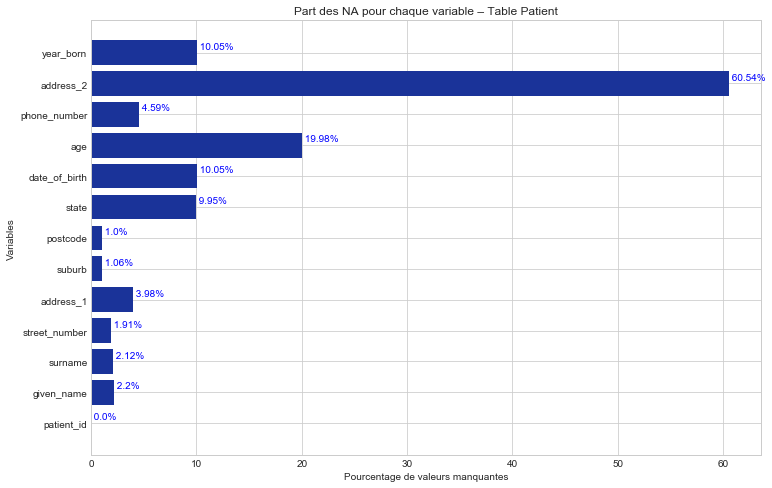

In [184]:
pourc_na = list(df_patient.isna().sum() / df_patient.shape[0] * 100)

plt.figure(figsize=(12, 8))
plt.title('Part des NA pour chaque variable – Table Patient')
plt.barh(df_patient.columns, pourc_na,
         color=color)
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Variables')

for i, v in enumerate(pourc_na):
    plt.text(v, i+0.2, " "+str(round(v, 2))+"%", color='blue', va='center')

Pour la table `pcr` :

In [29]:
df_pcr.isna().sum()

patient_id    0
pcr           0
dtype: int64

Certaines observations sont manquantes dans la table `patient`. Notamment, pour la variable `adresse_2` et `age`. On ne compte aucune valeur manquante pour la table PCR.

## Table PCR : Cohérence des variables

> Pour la variable `pcr`, on remarque que les modalités sont différentes. On peut harmoniser les modalités en ne conservant qu'une seule nomenclature.

In [177]:
df_pcr.pcr.value_counts()

N           3482
Negative    3134
Positive    1283
P            901
Name: pcr, dtype: int64

In [179]:
df_pcr.pcr = df_pcr.pcr.replace({'Negative': 'N', 'Positive': 'P'})

In [182]:
df_pcr.pcr.value_counts()

N    6616
P    2184
Name: pcr, dtype: int64

> Pour la variable `patient_id`, on remarque que 70 valeurs sont dupliquées

In [215]:
id_pcr_duplicated = df_pcr.patient_id[df_pcr.patient_id.duplicated(False)]
len(id_pcr_duplicated)

70

On va considérer comme valeur dupliquées lorsque le patient et le test sont identiques pour deux observations. Il s'agit ici des "vraies" données dupliquées qui peuvent être donc retirés.

In [221]:
all_dupli_table_pcr = df_pcr[df_pcr.duplicated(subset=["patient_id","pcr"], keep=False)]

In [232]:
len(all_dupli_table_pcr)

42

In [ ]:
# fonction pour drop duplicated :  df_pcr[df_pcr.duplicated(subset=["patient_id","pcr"], keep='first')]

Les valeurs restantes sont celles qui ont un **identifiant identique**, mais un résultat **pcr différent**.

In [247]:
pcrdiff_common_id = df_pcr.iloc[np.setdiff1d(id_pcr_duplicated.index, all_dupli_table_pcr.index)]

In [248]:
len(pcrdiff_common_id)

28

## Table Patient : Cohérence de chacune des variables

Focalisons nous sur les variables de la table patient :  
- `id` : il s'agit d'un identifiant unique, on peut donc vérifier la présence de doublons si deux `id` sont identiques.
- `date_of_birth` et `age` : ces deux variables sont assez redondantes car fournissent la même information. Un premier moyen de juger de la cohérence de ce jeu de données et de vérifier si l'age et la date de naissance corroborent.
- `postcode`, `suburb`, `state` : on peut vérifier si les informations de localisation sont cohérents entre eux et au sein de chacune des colonnes.

Cette première fonction permet de convertir les dates.

In [136]:
def convert_to_date(i):
    """
    Convert a float value to a date. 
    If the date isn't convertible, return the date in string.
    """
    
    if not(np.isnan(i)):
        str_date = str(int(i))
        try :
            return pd.to_datetime(str_date, format='%Y%m%d')
        except : 
            return str_date

In [37]:
col_date = df_patient.date_of_birth.apply(convert_to_date)

On vérifie les dates qui n'ont pas pu être converties (en dehors des NA)

In [39]:
date_noconvert = col_date[[isinstance(value, str) for value in col_date]]

On voit que certaines dates sont invraisemblables :  $1903/05/39$, $1954/12/42$ ou $1933/99/19$. On comptabilise 174 individus dans ce cas. Pour essayer de comprendre pourquoi ces données ne sont pas utilisables, on peut comparer les mêmes indices avec l'âge du patient.

In [40]:
compare_date = pd.DataFrame([df_patient.age[date_noconvert.index],date_noconvert]).T

In [41]:
compare_date

,age,date_of_birth
40,36,19030539
145,24,19179318
244,39,19541242
481,NaN,19990353
539,39,19328814
...,...,...
19843,24,19181527
19875,7,19339919
19928,12,19550480
19949,32,19910237


In [42]:
compare_date.date_of_birth.apply(lambda x : x[:4])

40       1903
145      1917
244      1954
481      1999
539      1932
         ... 
19843    1918
19875    1933
19928    1955
19949    1991
19952    1912
Name: date_of_birth, Length: 174, dtype: object

In [45]:
2020 - df_patient.age[indice_test] 

0        1988.0
1        1986.0
2        1998.0
3        1990.0
4        1989.0
          ...  
19995       NaN
19996    1989.0
19997    1994.0
19998    1995.0
19999    1994.0
Name: age, Length: 19826, dtype: float64

In [92]:
lambda x: 'True' if x <= 4 else 'False'

<function __main__.<lambda>(x)>

In [103]:
fun = lambda x : 2020 - int(str(x)[:4]) if x is not('nan') else np.nan

In [105]:
df_patient.date_of_birth

0        19710708.0
1        19120921.0
2        19810905.0
3        19840809.0
4        19340430.0
            ...    
19995    19570210.0
19996    19590619.0
19997           NaN
19998    19140304.0
19999    19230521.0
Name: date_of_birth, Length: 20000, dtype: float64

In [110]:
df_patient.date_of_birth.isna().sum()

2011

In [121]:
def get_year(value):
    if not(np.isnan(value)):
        return str(value)[:4]

In [123]:
df_patient["year_born"] = df_patient.date_of_birth.apply(get_year)

In [135]:
df_patient[df_patient.year_born == "1290"]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,year_born
8882,258272,jack,jessup,509.0,stone place,batlow,None,qld,12900410.0,34.0,08 77804659,mayflower retrmnt vlge,1290


In [132]:
df_patient.year_born.value_counts()

1983    223
1976    223
1921    217
1911    213
1993    207
       ... 
1925    152
1944    150
1994    147
1912    146
1290      1
Name: year_born, Length: 101, dtype: int64

In [108]:
for i in df_patient.date_of_birth.values:
    if not(np.nan):
        print(int(str(x)[:4]))

In [69]:
def get_year(x):
    if isinstance(x, int) and (x is not None) :
        return x.year()

In [70]:
col_date.apply(get_year)

0        None
1        None
2        None
3        None
4        None
         ... 
19995    None
19996    None
19997    None
19998    None
19999    None
Name: date_of_birth, Length: 20000, dtype: object

In [193]:
col_date[indice]

68    1911-02-12 00:00:00
18    1907-07-04 00:00:00
23    1929-03-09 00:00:00
38    1992-10-05 00:00:00
28    1952-02-29 00:00:00
70    1913-05-22 00:00:00
45    1937-08-19 00:00:00
73    1936-03-22 00:00:00
68    1911-02-12 00:00:00
26    1975-07-22 00:00:00
37    1913-04-21 00:00:00
11    1920-10-21 00:00:00
3     1984-08-09 00:00:00
75    1912-11-30 00:00:00
71    1968-05-05 00:00:00
79    1901-11-22 00:00:00
89    1936-12-11 00:00:00
62    1966-05-15 00:00:00
56    1959-08-26 00:00:00
62    1966-05-15 00:00:00
Name: date_of_birth, dtype: object

In [194]:
2020 - df_patient.age[indice]

68    1993.0
18       NaN
23    1997.0
38       NaN
28    2012.0
70       NaN
45    1981.0
73    2013.0
68    1993.0
26    1995.0
37    1992.0
11    1982.0
3     1990.0
75    1993.0
71    1988.0
79    1996.0
89       NaN
62    1993.0
56    1983.0
62    1993.0
Name: age, dtype: float64

In [153]:
col_date

0        1971-07-08 00:00:00
1        1912-09-21 00:00:00
2        1981-09-05 00:00:00
3        1984-08-09 00:00:00
4        1934-04-30 00:00:00
                ...         
19995    1957-02-10 00:00:00
19996    1959-06-19 00:00:00
19997                   None
19998    1914-03-04 00:00:00
19999    1923-05-21 00:00:00
Name: date_of_birth, Length: 20000, dtype: object

In [ ]:
def verif_corehence_date(date, date_birth):
    

### Identifiant

On comptabilise 403 élements dupliqués.

In [251]:
id_duplicated = df_patient.patient_id[df_patient["patient_id"].duplicated(False)]
len(id_duplicated)

403

On peut prendre l'exemple d'un doublon : 

In [161]:
df_pcr[df_pcr.patient_id == 119816]

,patient_id,pcr
7602,119816,N


In [152]:
df_patient[df_patient.patient_id == 119816]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,year_born
1456,119816,jed,rollins,63.0,mauldon street,macquarie fields,4169,nsw,19010805.0,NaN,07 73786737,None,1901
2377,119816,sam,iasenzaniro,12.0,booroondara street,brighton,6153,sa,19621207.0,NaN,03 90915909,None,1962


La seule valeur **identique** est l'identifiant unique, tandis que les autres valeurs sont différentes. On ne peut pas savoir à quel patient appartient le test. On va donc créer une variable boolean pour savoir si ce patient était en double lors du merge des deux tables.

In [174]:
df_patient["is_duplicated"] = df_patient[id_duplicated.index]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,year_born
22,427069,mystique,white,85.0,herington street,east maitland,6000,qld,NaN,21.0,07 24234495,None,None
24,299041,harrison,neumann,60.0,eggleston crescent,tweed heads,2560,vic,19700617.0,22.0,04 13196831,None,1970
49,655839,teileah,callado,49.0,darambal street,dulwich hill,6018,vic,19280717.0,20.0,02 56099733,None,1928
107,448951,connor,clarke,15.0,mudie place,elwood,7250,nsw,19740809.0,30.0,02 23822510,coorabil,1974
153,301664,luke,roff,63.0,torrens street,lilydale,6230,vic,19830818.0,38.0,04 84667821,calandra,1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19824,961465,yasmin,rees,7.0,altson circuit,bundaberg,2444,vic,19121010.0,21.0,03 13203244,None,1912
19854,520331,sophie,webb,5.0,jonsson court,frenchs forest,2350,tas,19540805.0,36.0,08 68970096,cleveland waters,1954
19868,563609,hannah,deakin,4.0,newmarch place,holden hill,6069,vic,19250722.0,26.0,07 47947971,dusty corner,1925
19896,535564,marcus,reinbach,2.0,wangara street,hazelbrook,3931,vic,19670124.0,30.0,08 38366451,northbridge marina,1967


### La date de naissance et l'âge

## Fonctions pour le DataFrame 

In [231]:
def clean_data(dataframe: pd.DataFrame, who="patient"):
    """
    Clean dataframe
    """
    
    if who == 'patient':
        pass
    
    
    
    elif who == 'pcr':
        dataframe.pcr = dataframe.pcr.replace({'Negative': 'N', 'Positive': 'P'})
        
        return dataframe

## La gestion des doublons 

Ecrire une fonction python `detect_duplicates` qui prend en parametère le dataframe `df_patient` et qui renvoit un nouveau dataframe après suppression des doublons. 

On estimera le pourcentage de données dupliquées. 

*Attention, les données dupliquées ne sont pas identiques. Il faut imaginer des problèmes de saisies de données (typos, information manquante etc.)*

In [15]:
def detect_duplicates(dataframe:pd.DataFrame):
    pass